## **dependencies**

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
pd.set_option('future.no_silent_downcasting', True)
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, metrics, models, optimizers, losses
import matplotlib.pyplot as plt
import sklearn.metrics
!pip install graphviz
import graphviz
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## **data**

In [2]:
data = pd.read_csv('BO_Training_Dataset.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print("Number of categorical featues including Product id and target variable : " , data.select_dtypes(exclude=['int', 'float']).shape[1])
print('Features : ', data.columns.values)

Number of data points :  1048575
Number of features :  23
Number of categorical featues including Product id and target variable :  7
Features :  ['sku' 'national_inv' 'lead_time' 'in_transit_qty' 'forecast_3_month'
 'forecast_6_month' 'forecast_9_month' 'sales_1_month' 'sales_3_month'
 'sales_6_month' 'sales_9_month' 'min_bank' 'potential_issue'
 'pieces_past_due' 'perf_6_month_avg' 'perf_12_month_avg' 'local_bo_qty'
 'deck_risk' 'oe_constraint' 'ppap_risk' 'stop_auto_buy' 'rev_stop'
 'went_on_backorder']


## **Subset of data**

In [3]:
data = data[:50000]

## **data processing**

In [4]:
# 1
data = data.drop(columns=['sku'])

# 2
num_features = data.select_dtypes(include=['float64', 'int64'])

# 3
data.loc[:, 'perf_12_month_avg'] = data['perf_12_month_avg'].replace(-99.0, np.nan)
data.loc[:, 'perf_6_month_avg'] = data['perf_6_month_avg'].replace(-99.0, np.nan)

# 4
imputer = IterativeImputer(random_state=2024)
df_imputed = pd.DataFrame(imputer.fit_transform(num_features), columns=num_features.columns)

# 5
skewness = df_imputed.skew()
print("Skewness:\n", skewness)

# 6
df_transformed = PowerTransformer(method='yeo-johnson').fit_transform(df_imputed)
df_transformed = pd.DataFrame(df_transformed, columns=df_imputed.columns)

# 7
scaler = RobustScaler()
df_scaled_num = pd.DataFrame(scaler.fit_transform(df_transformed), columns=df_transformed.columns)

# 8
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    data[col] = data[col].replace({'No': 0.0, 'Yes': 1.0})
    data[col] = data[col].fillna(-1).astype(int)

# 9
df_final = pd.concat([df_scaled_num, data[cat_cols]], axis=1)
df_final.info()

Skewness:
 national_inv         219.791728
lead_time              4.309722
in_transit_qty       127.284487
forecast_3_month     139.139632
forecast_6_month     143.040866
forecast_9_month     139.756086
sales_1_month        120.366694
sales_3_month        109.846240
sales_6_month        114.630824
sales_9_month        105.200642
min_bank             123.089131
pieces_past_due      136.182197
perf_6_month_avg      -3.139691
perf_12_month_avg     -3.265073
local_bo_qty         123.937608
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national_inv       50000 non-null  float64
 1   lead_time          50000 non-null  float64
 2   in_transit_qty     50000 non-null  float64
 3   forecast_3_month   50000 non-null  float64
 4   forecast_6_month   50000 non-null  float64
 5   forecast_9_month   50000 non-null  float64
 

## **Features and target variable**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# 10
X = df_final.copy().drop(['went_on_backorder'],axis=1)
Y = df_final['went_on_backorder'].copy()

## **Feature elimination: VIF**

In [6]:
# 11
def calculate_vif(df, threshold=10):
    """Calculate VIF and iteratively remove features with high VIF values."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    while vif_data["VIF"].max() > threshold:
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        print(f"Removing {max_vif_feature} with VIF {vif_data['VIF'].max():.2f}")

        df = df.drop(columns=[max_vif_feature])

        vif_data = pd.DataFrame()
        vif_data["Feature"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print("Final features after VIF elimination:")
    print(vif_data)
    return df

X_reduced = calculate_vif(X.copy(), threshold=5)

print(Y.shape)
print(X_reduced.shape)

Y = Y[X_reduced.index]

print(Y.shape)
print(X_reduced.shape)

X_train, X_test, y_train, y_test = train_test_split(
   X_reduced, Y, test_size=0.33, random_state=2024, stratify = Y)

Removing sales_6_month with VIF 55.18
Removing forecast_6_month with VIF 27.92
Removing sales_3_month with VIF 20.50
Removing perf_12_month_avg with VIF 12.27
Removing sales_1_month with VIF 8.85
Removing forecast_9_month with VIF 7.97
Final features after VIF elimination:
             Feature       VIF
0       national_inv  1.025048
1          lead_time  1.067885
2     in_transit_qty  2.280936
3   forecast_3_month  2.336416
4      sales_9_month  2.386766
5           min_bank  3.754253
6    pieces_past_due  1.062057
7   perf_6_month_avg  1.173806
8       local_bo_qty  1.073694
9    potential_issue  1.004960
10         deck_risk  1.456493
11     oe_constraint  1.001922
12         ppap_risk  1.144044
13     stop_auto_buy  2.821066
14          rev_stop  1.002246
(50000,)
(50000, 15)
(50000,)
(50000, 15)


## **Features normalization**

In [7]:
# 12
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)

print("Min value in normalized X_train:", X_train_normalized.min().min())
print("Max value in normalized X_train:", X_train_normalized.max().max())

Min value in normalized X_train: 0.0
Max value in normalized X_train: 1.0


In [8]:
# 13
X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
X_test_normalized = X_test_normalized.clip(0, 1)
print("Min value in normalized X_test after clipping:", X_test_normalized.min().min())
print("Max value in normalized X_test after clipping:", X_test_normalized.max().max())

Min value in normalized X_test after clipping: 0.0
Max value in normalized X_test after clipping: 1.0


## **Metrics**

In [9]:
METRICS = [
    # metrics.BinaryCrossentropy(name='cross_entropy'),
    metrics.MeanSquaredError(name='brier_score'),
    metrics.TruePositives(name='tp'),
    metrics.FalsePositives(name='fp'),
    metrics.TrueNegatives(name='tn'),
    metrics.FalseNegatives(name='fn'),
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')]

## **Shallow feed forward neural network**

In [11]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    input_dim = X_train_normalized.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', name='Dense_128'),
        layers.BatchNormalization(),
        layers.Dropout(0.3, name='Dropout_1'),
        layers.Dense(64, activation='relu', name='Dense_64'),
        layers.BatchNormalization(),
        layers.Dropout(0.2, name='Dropout_2'),
        layers.Dense(1, activation='sigmoid', name='Output')])


    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

input_dim = X_train_normalized.shape[1]
base_model = make_model(metrics=METRICS)

def visualize_model_graph(model):
    dot = graphviz.Digraph(format='png')
    dot.node('Input', 'Input Layer\n' + str(input_dim) + ' Features', shape='box', color='lightblue')

    for idx, layer in enumerate(model.layers):
        layer_name = layer.name
        if isinstance(layer, layers.Dense):
            dot.node(layer_name, f'{layer_name}\n{layer.units} Neurons', shape='ellipse')
        elif isinstance(layer, layers.Dropout):
            dot.node(layer_name, layer_name, shape='diamond')

        if idx == 0:
            dot.edge('Input', layer_name)
        else:
            dot.edge(model.layers[idx - 1].name, layer_name)

    output_layer = model.layers[-1].name
    dot.node('Output', 'Output Layer\n1 Neuron', shape='ellipse', color='lightgreen')
    dot.edge(output_layer, 'Output')

    return dot

dnn_graph = visualize_model_graph(base_model)
dnn_graph.render('dnn_model_graph')
dnn_graph.view()

'dnn_model_graph.png'

## **Model stopping criteria**

In [12]:
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5,
        mode='max',
        restore_best_weights=True)

base_model = make_model()
base_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_128 (Dense)                    │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_64 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 384 (1.50 KB)

## **test run base model**

In [13]:
base_model.predict(X_train_normalized[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


array([[0.5052603 ],
       [0.53755635],
       [0.5684891 ],
       [0.49792725],
       [0.5328512 ],
       [0.5408785 ],
       [0.54964066],
       [0.5329275 ],
       [0.5394186 ],
       [0.51883715]], dtype=float32)

In [14]:
BATCH_SIZE = 2048
EPOCHS = 100

X_train_array = X_train_normalized.to_numpy() if isinstance(X_train_normalized, pd.DataFrame) else X_train
y_train_array = y_train.to_numpy().reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)

print("X_train shape:", X_train_array.shape)
print("Train labels shape:", y_train_array.shape)

results = base_model.evaluate(X_train_array, y_train_array, batch_size=BATCH_SIZE, verbose=0)

print(f"Loss: {results[0]:0.4f}")

X_train shape: (33500, 15)
Train labels shape: (33500, 1)
Loss: 0.7622


## **Set initial bias**

In [15]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
initial_bias

Examples:
    Total: 33500
    Positive: 336 (1.00% of total)



array([-4.59210907])

In [16]:
pos/total

0.010029850746268656

In [17]:
base_model = make_model(output_bias=initial_bias)
base_model.predict(X_train_normalized[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[0.45364612],
       [0.49722916],
       [0.4626694 ],
       [0.41156068],
       [0.5106071 ],
       [0.4099179 ],
       [0.45078143],
       [0.5111365 ],
       [0.43601906],
       [0.47072798]], dtype=float32)

In [18]:
results = base_model.evaluate(X_train_normalized, y_train_array, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6604


In [19]:
X_test_array = X_test_normalized.to_numpy() if isinstance(X_test_normalized, pd.DataFrame) else X_test
y_test_array = y_test.to_numpy().reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test

print("X_test shape:", X_test_array.shape)
print("Test labels shape:", y_test_array.shape)

X_test shape: (16500, 15)
Test labels shape: (16500, 1)


## **Checkpoint the initial weights**

In [20]:
import os, tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
base_model.save_weights(initial_weights)

In [21]:
base_model = make_model()
base_model.load_weights(initial_weights)
base_model.layers[-1].bias.assign([0.0])

y_train_array = y_train_array.reshape(-1, 1) if y_train_array.ndim == 1 else y_train_array
y_test_array = y_test_array.reshape(-1, 1) if y_test_array.ndim == 1 else y_test_array

print("X_train shape:", X_train_array.shape)
print("Train labels shape:", y_train_array.shape)
print("X_test shape:", X_test_array.shape)
print("Test labels shape:", y_test_array.shape)

zero_bias_history = base_model.fit(
    X_train_array,
    y_train_array,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
    verbose=0)

X_train shape: (33500, 15)
Train labels shape: (33500, 1)
X_test shape: (16500, 15)
Test labels shape: (16500, 1)


## **Confirm bias fix helps**

In [22]:
base_model = make_model()
base_model.load_weights(initial_weights)

careful_bias_history = base_model.fit(
    X_train_array,
    y_train_array,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
    verbose=0)

In [23]:
import matplotlib.pyplot as plt

def plot_loss(history, label, n):
  colors = ['blue', 'green', 'red', 'orange']

  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

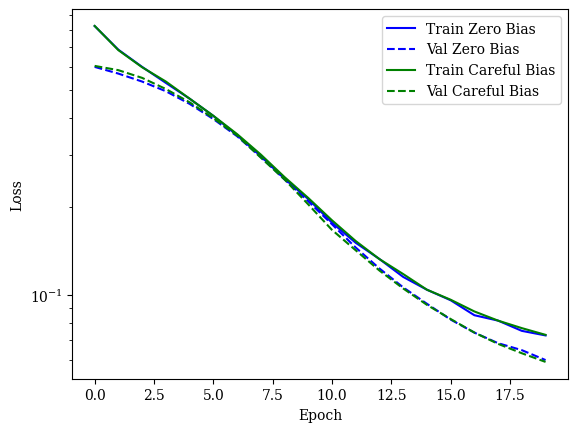

In [24]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## **Train model**

In [25]:
EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

baseline_history = base_model.fit(
    X_train_array,
    y_train_array,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_array, y_test_array))

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9888 - auc: 0.6591 - brier_score: 0.0120 - fn: 185.2222 - fp: 31.6667 - loss: 0.0685 - prc: 0.0249 - precision: 0.0284 - recall: 0.0051 - tn: 18977.9453 - tp: 1.1667 - val_accuracy: 0.9899 - val_auc: 0.8149 - val_brier_score: 0.0102 - val_fn: 166.0000 - val_fp: 0.0000e+00 - val_loss: 0.0633 - val_prc: 0.0697 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 16334.0000 - val_tp: 0.0000e+00
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9894 - auc: 0.6600 - brier_score: 0.0118 - fn: 184.1667 - fp: 23.0000 - loss: 0.0669 - prc: 0.0217 - precision: 0.0854 - recall: 0.0105 - tn: 18986.6113 - tp: 2.2222 - val_accuracy: 0.9899 - val_auc: 0.8219 - val_brier_score: 0.0100 - val_fn: 166.0000 - val_fp: 0.0000e+00 - val_loss: 0.0601 - val_prc: 0.0729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 16334.0000 - val_tp: 0.0000e+00
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accu

## **training history**

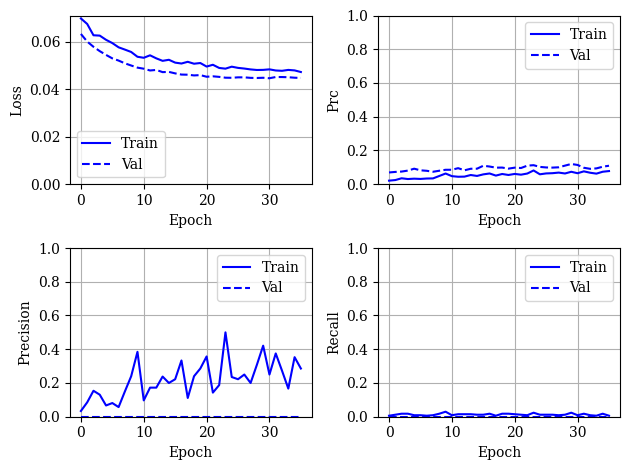

In [26]:
def plot_metrics(history):
  colors = ['blue', 'green', 'red', 'orange']
  metrics = ['loss', 'prc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend(), plt.grid(),
    plt.tight_layout()

plot_metrics(baseline_history)

## **Evaluate metrics**

In [27]:
train_predictions_baseline = base_model.predict(X_train_array, batch_size=BATCH_SIZE)
test_predictions_baseline = base_model.predict(X_test_array, batch_size=BATCH_SIZE)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [28]:
def plot_cm(labels, predictions, threshold=0.5):
    predicted_labels = (predictions > threshold).astype(int)
    cm = confusion_matrix(labels, predicted_labels)

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f'DNN Model Confusion Matrix @ {threshold:.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    tn, fp, fn, tp = cm.ravel()

    print(f'Correctly predicted "No Backorder" (True Negatives): {tn}')
    print(f'Incorrectly predicted "Backorder" (False Positives): {fp} (false alarm)')
    print(f'Incorrectly predicted "No Backorder" (False Negatives): {fn} (missed backorder)')
    print(f'Correctly predicted "Backorder" (True Positives): {tp}')
    print(f'Total Actual Backorders: {np.sum(cm[1])}')

    plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions_baseline_labels = (test_predictions_baseline > 0.5).astype(int)
print(classification_report(y_test_array, test_predictions_baseline_labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



loss :  0.0447557307779789
compile_metrics :  0.009411105886101723

Correctly predicted "No Backorder" (True Negatives): 16334
Incorrectly predicted "Backorder" (False Positives): 0 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 166 (missed backorder)
Correctly predicted "Backorder" (True Positives): 0
Total Actual Backorders: 166


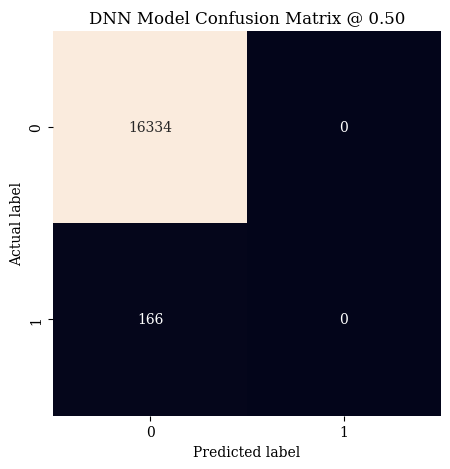

In [30]:
from sklearn.metrics import confusion_matrix

baseline_results = base_model.evaluate(X_test_array, y_test_array,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(base_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test_array, test_predictions_baseline)

Correctly predicted "No Backorder" (True Negatives): 16237
Incorrectly predicted "Backorder" (False Positives): 97 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 142 (missed backorder)
Correctly predicted "Backorder" (True Positives): 24
Total Actual Backorders: 166


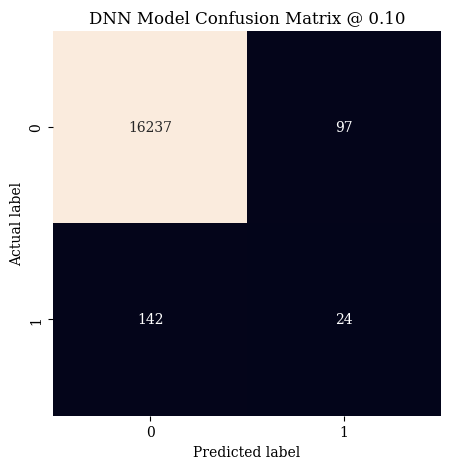

Correctly predicted "No Backorder" (True Negatives): 13220
Incorrectly predicted "Backorder" (False Positives): 3114 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 35 (missed backorder)
Correctly predicted "Backorder" (True Positives): 131
Total Actual Backorders: 166


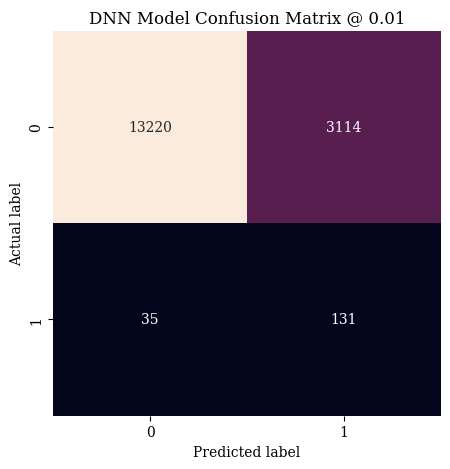

In [65]:
plot_cm(y_test_array, test_predictions_baseline, threshold=0.1)
plot_cm(y_test_array, test_predictions_baseline, threshold=0.01)

## **confusion matrix, ROC and prc**

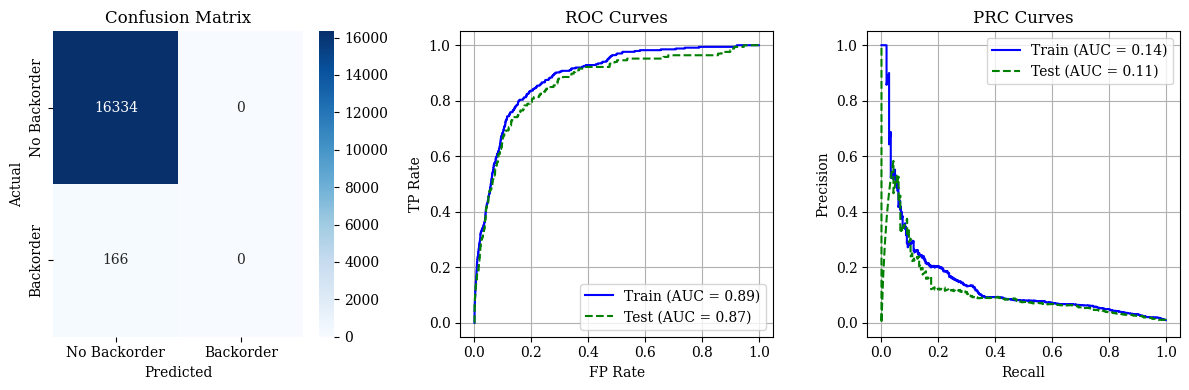

In [88]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Confusion matrix
cm = confusion_matrix(y_test_array, test_predictions_baseline_labels)

colors = ['b', 'g']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Confusion matrix heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

plot_roc("Train", y_train_array, train_predictions_baseline, color=colors[0], ax=axes[1])
plot_roc("Test", y_test_array, test_predictions_baseline, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves')
axes[1].set_xlabel('FP Rate')
axes[1].set_ylabel('TP Rate')
axes[1].legend(loc='best')
axes[1].grid(True)

# PRC
def plot_prc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    prc_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')

plot_prc("Train", y_train_array, train_predictions_baseline, color=colors[0], ax=axes[2])
plot_prc("Test", y_test_array, test_predictions_baseline, color=colors[1], linestyle='--', ax=axes[2])

axes[2].set_title('PRC Curves')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].legend(loc='best')
axes[2].grid(True)

plt.tight_layout()
plt.show()

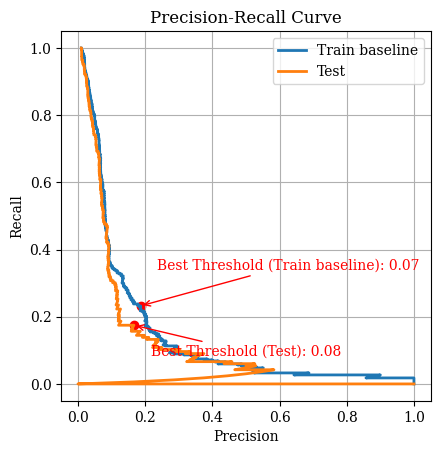

In [93]:
def plot_prc(name, labels, predictions, offset_x=0.05, offset_y=0.05, **kwargs):
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, predictions)

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_threshold_index = f1_scores.argmax()
    best_threshold = thresholds[best_threshold_index]
    best_precision = precision[best_threshold_index]
    best_recall = recall[best_threshold_index]

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.scatter(best_precision, best_recall, color='red', marker='o')
    plt.annotate(
        f'Best Threshold ({name}): {best_threshold:.2f}',
        xy=(best_precision, best_recall),
        xytext=(best_precision + offset_x, best_recall + offset_y),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10,
        color='red',
        verticalalignment='bottom')

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    return best_threshold

best_threshold_train = plot_prc("Train baseline", y_train.values, train_predictions_baseline, offset_y=0.1)
best_threshold_test = plot_prc("Test", y_test.values, test_predictions_baseline, offset_y=-0.1)

plt.legend(loc='best')
plt.title("Precision-Recall Curve")
plt.show()

Correctly predicted "No Backorder" (True Negatives): 16195
Incorrectly predicted "Backorder" (False Positives): 139 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 139 (missed backorder)
Correctly predicted "Backorder" (True Positives): 27
Total Actual Backorders: 166


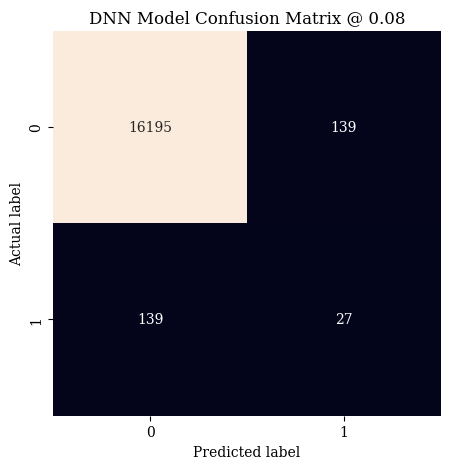

In [95]:
plot_cm(y_test_array, test_predictions_baseline, threshold=0.08)

## **Class weights**

In [31]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 49.85


## **Train model with class weights**

In [32]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)


weighted_history = weighted_model.fit(
    X_train_array,
    y_train_array[:X_train_array.shape[0]],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_array, y_test_array),
    class_weight=class_weight)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.7401 - auc: 0.6301 - brier_score: 0.1643 - fn: 239.3889 - fp: 9774.0557 - loss: 0.9334 - prc: 0.0183 - precision: 0.0102 - recall: 0.2808 - tn: 25569.5547 - tp: 113.0000 - val_accuracy: 0.8066 - val_auc: 0.8426 - val_brier_score: 0.2349 - val_fn: 36.0000 - val_fp: 3155.0000 - val_loss: 0.6628 - val_prc: 0.0810 - val_precision: 0.0396 - val_recall: 0.7831 - val_tn: 13179.0000 - val_tp: 130.0000
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6027 - auc: 0.8102 - brier_score: 0.2894 - fn: 29.1667 - fp: 7517.8335 - loss: 0.6074 - prc: 0.0407 - precision: 0.0199 - recall: 0.8346 - tn: 11491.7773 - tp: 157.2222 - val_accuracy: 0.9481 - val_auc: 0.7475 - val_brier_score: 0.2015 - val_fn: 113.0000 - val_fp: 743.0000 - val_loss: 0.5953 - val_prc: 0.0711 - val_precision: 0.0666 - val_recall: 0.3193 - val_tn: 15591.0000 - val_tp: 53.0000
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6365 - au

## **training history**

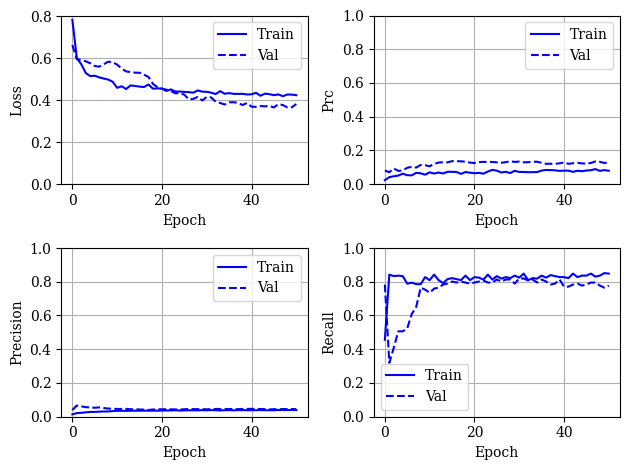

In [33]:
plot_metrics(weighted_history)

## **Evaluate metrics**

In [34]:
train_predictions_weighted = weighted_model.predict(X_train_array, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test_array, batch_size=BATCH_SIZE)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [35]:
from sklearn.metrics import confusion_matrix,classification_report

test_predictions_weighted_labels = (test_predictions_weighted > 0.5).astype(int)
print(classification_report(y_test_array, test_predictions_weighted_labels))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     16334
           1       0.04      0.78      0.08       166

    accuracy                           0.83     16500
   macro avg       0.52      0.80      0.50     16500
weighted avg       0.99      0.83      0.90     16500



## **Confusion matrix, ROC and PRC**

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

weighted_results = weighted_model.evaluate(X_test_array,
                                           y_test_array,
                                           batch_size=BATCH_SIZE,
                                           verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

# 1. Classification report
print("Classification Report:")
print(classification_report(y_test_array, test_predictions_weighted_labels))

loss :  0.38159874081611633
compile_metrics :  0.12547414004802704

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     16334
           1       0.04      0.78      0.08       166

    accuracy                           0.83     16500
   macro avg       0.52      0.80      0.50     16500
weighted avg       0.99      0.83      0.90     16500



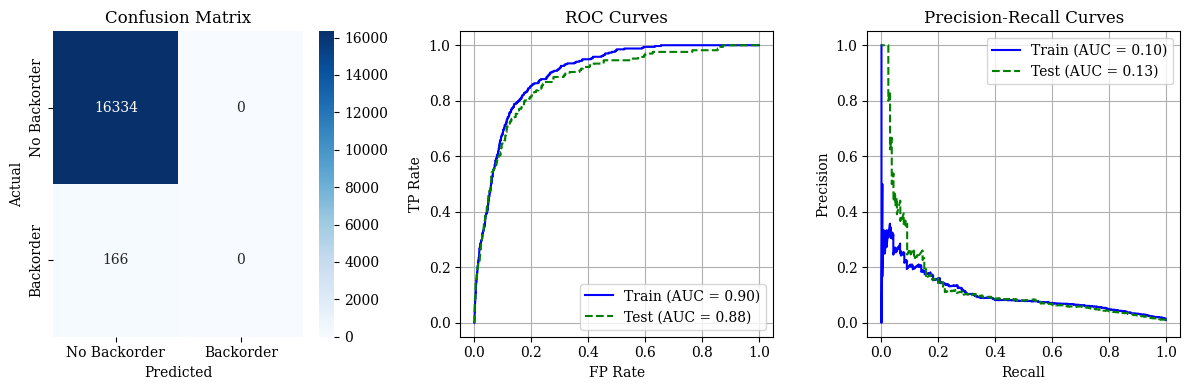

In [90]:
colors = ['b', 'g']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

plot_roc("Train", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[1])
plot_roc("Test", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves')
axes[1].set_xlabel('FP Rate')
axes[1].set_ylabel('TP Rate')
axes[1].legend(loc='best')
axes[1].grid(True)

# PRC
def plot_prc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    prc_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')

plot_prc("Train", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[2])
plot_prc("Test", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[2])

axes[2].set_title('Precision-Recall Curves')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].legend(loc='best')
axes[2].grid(True)

plt.tight_layout()
plt.show()

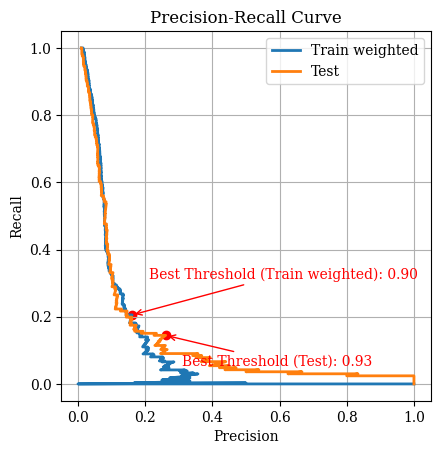

In [85]:
def plot_prc(name, labels, predictions, offset_x=0.05, offset_y=0.05, **kwargs):
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, predictions)

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_threshold_index = f1_scores.argmax()
    best_threshold = thresholds[best_threshold_index]
    best_precision = precision[best_threshold_index]
    best_recall = recall[best_threshold_index]

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.scatter(best_precision, best_recall, color='red', marker='o')
    plt.annotate(
        f'Best Threshold ({name}): {best_threshold:.2f}',
        xy=(best_precision, best_recall),
        xytext=(best_precision + offset_x, best_recall + offset_y),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10,
        color='red',
        verticalalignment='bottom')

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    return best_threshold

best_threshold_train = plot_prc("Train weighted", y_train.values, train_predictions_weighted, offset_y=0.1)
best_threshold_test = plot_prc("Test", y_test.values, test_predictions_weighted, offset_y=-0.1)

plt.legend(loc='best')
plt.title("Precision-Recall Curve")
plt.show()

Correctly predicted "No Backorder" (True Negatives): 16267
Incorrectly predicted "Backorder" (False Positives): 67 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 144 (missed backorder)
Correctly predicted "Backorder" (True Positives): 22
Total Actual Backorders: 166


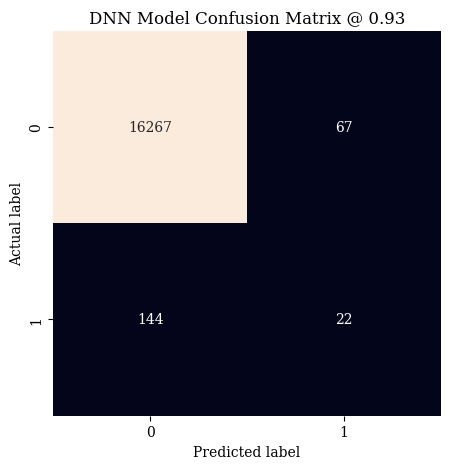

In [42]:
plot_cm(y_test_array, test_predictions_weighted, threshold=0.93)

## **Oversampled**

In [43]:
y_train_array = np.array(y_train).reshape(-1, 1)
bool_train_labels = y_train_array[:, 0] != 0
y_test_array = np.array(y_test).reshape(-1, 1)

In [44]:
X_train = X_train_normalized.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

pos_features = X_train.loc[bool_train_labels]
neg_features = X_train.loc[~bool_train_labels]

pos_labels = y_train.loc[bool_train_labels]
neg_labels = y_train.loc[~bool_train_labels]

In [45]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features), replace=True)
res_pos_features = pos_features.iloc[choices]
res_pos_labels = pos_labels.iloc[choices]
print(res_pos_features.shape)
print(res_pos_labels.shape)

(33164, 15)
(33164,)


In [46]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(66328, 15)

In [47]:
BUFFER_SIZE = len(resampled_features)
BATCH_SIZE = 2048

def make_ds(features, labels, batch_size=None):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  ds = ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  if batch_size:
    ds = ds.batch(BATCH_SIZE)
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [48]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [0.74312579 0.93006894 0.         0.39097413 0.45295826 0.3543139
 0.         0.98788768 0.         0.         0.         0.
 0.         1.         0.        ]

Label:  [1]


In [49]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch

print(resampled_steps_per_epoch)

0.50830078125
33


In [50]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_test_array, y_test_array)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.7262 - auc: 0.7738 - brier_score: 0.1898 - fn: 5580.3530 - fp: 8574.1475 - loss: 0.7341 - prc: 0.5716 - precision: 0.5327 - recall: 0.6531 - tn: 25571.6465 - tp: 12553.6172 - val_accuracy: 0.3352 - val_auc: 0.7819 - val_brier_score: 0.2609 - val_fn: 18.0000 - val_fp: 10951.0000 - val_loss: 0.7151 - val_prc: 0.0618 - val_precision: 0.0133 - val_recall: 0.8916 - val_tn: 5383.0000 - val_tp: 148.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7891 - auc: 0.8536 - brier_score: 0.1545 - fn: 3541.9119 - fp: 3987.3235 - loss: 0.4864 - prc: 0.8308 - precision: 0.7836 - recall: 0.8020 - tn: 13819.0293 - tp: 14431.5000 - val_accuracy: 0.2638 - val_auc: 0.7807 - val_brier_score: 0.2750 - val_fn: 14.0000 - val_fp: 12134.0000 - val_loss: 0.7436 - val_prc: 0.0651 - val_precision: 0.0124 - val_recall: 0.9157 - val_tn: 4200.0000 - val_tp: 152.0000
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 

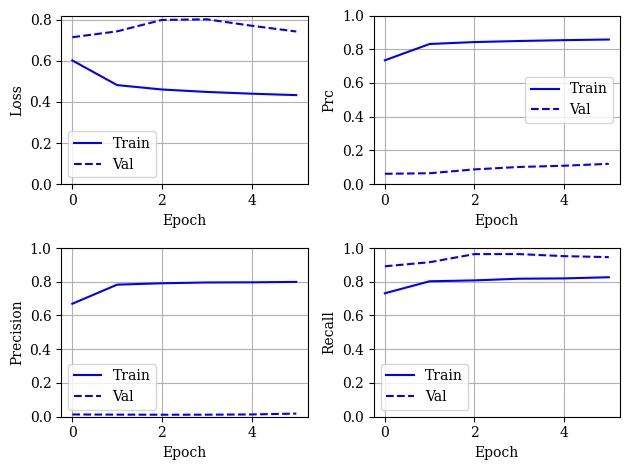

In [51]:
plot_metrics(resampled_history)

In [52]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

smaller_epochs = 10
total_epochs = EPOCHS

for i in range(total_epochs // smaller_epochs):
    resampled_history = resampled_model.fit(
        resampled_ds,
        epochs=smaller_epochs,
        steps_per_epoch=resampled_steps_per_epoch,
        validation_data=(val_ds),
        callbacks=[early_stopping])

    if resampled_model.stop_training:
        print("Early stopping triggered. Training stopped.")
        break

    train_loss = resampled_history.history['loss'][-1]
    val_loss = resampled_history.history['val_loss'][-1]
    print(f"Epoch chunk {i+1}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.5979 - auc: 0.6606 - brier_score: 0.2476 - fn: 5617.5293 - fp: 14108.6475 - loss: 0.7424 - prc: 0.5440 - precision: 0.4163 - recall: 0.6523 - tn: 20037.1465 - tp: 12516.4414 - val_accuracy: 0.3019 - val_auc: 0.7867 - val_brier_score: 0.2664 - val_fn: 15.0000 - val_fp: 11504.0000 - val_loss: 0.7262 - val_prc: 0.0622 - val_precision: 0.0130 - val_recall: 0.9096 - val_tn: 4830.0000 - val_tp: 151.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.7868 - auc: 0.8516 - brier_score: 0.1558 - fn: 3539.9707 - fp: 4056.9707 - loss: 0.4899 - prc: 0.8294 - precision: 0.7795 - recall: 0.8033 - tn: 13749.3828 - tp: 14433.4414 - val_accuracy: 0.2567 - val_auc: 0.7730 - val_brier_score: 0.2748 - val_fn: 15.0000 - val_fp: 12249.0000 - val_loss: 0.7432 - val_prc: 0.0603 - val_precision: 0.0122 - val_recall: 0.9096 - val_tn: 4085.0000 - val_tp: 151.0000
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.

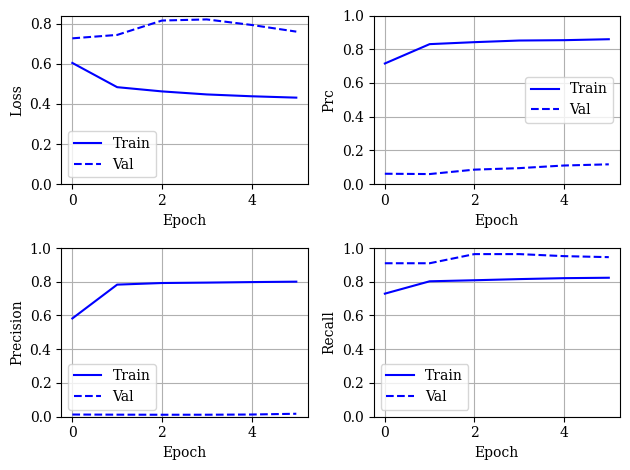

In [53]:
plot_metrics(resampled_history)

In [54]:
train_predictions_resampled = resampled_model.predict(resampled_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test_array, batch_size=BATCH_SIZE)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [55]:
from sklearn.metrics import confusion_matrix,classification_report

test_predictions_resampled_labels = (test_predictions_resampled > 0.5).astype(int)
print(classification_report(y_test_array, test_predictions_resampled_labels))

              precision    recall  f1-score   support

           0       1.00      0.46      0.63     16334
           1       0.02      0.95      0.03       166

    accuracy                           0.47     16500
   macro avg       0.51      0.71      0.33     16500
weighted avg       0.99      0.47      0.63     16500



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63     16334
           1       0.02      0.95      0.03       166

    accuracy                           0.47     16500
   macro avg       0.51      0.71      0.33     16500
weighted avg       0.99      0.47      0.63     16500



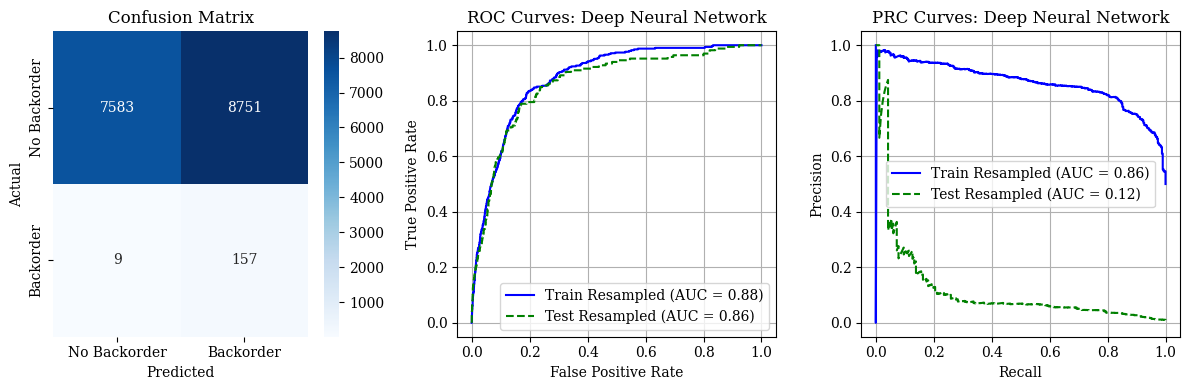

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Classification report
print("Classification Report:")
print(classification_report(y_test_array, test_predictions_resampled_labels))

# Confusion matrix
cm = confusion_matrix(y_test_array, test_predictions_resampled_labels)
colors = ['b', 'g']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

plot_roc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[0], ax=axes[1])
plot_roc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves: Deep Neural Network')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='best')
axes[1].grid(True)

# PRC
def plot_prc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    prc_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')

plot_prc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[0], ax=axes[2])
plot_prc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[1], linestyle='--', ax=axes[2])

axes[2].set_title('PRC Curves: Deep Neural Network')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].legend(loc='best')
axes[2].grid(True)

plt.tight_layout()
plt.show()

loss :  0.7595857381820679
compile_metrics :  0.2814931869506836

Correctly predicted "No Backorder" (True Negatives): 7583
Incorrectly predicted "Backorder" (False Positives): 8751 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 9 (missed backorder)
Correctly predicted "Backorder" (True Positives): 157
Total Actual Backorders: 166


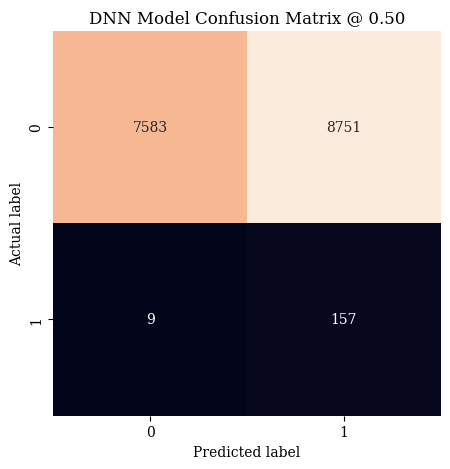

In [57]:
resampled_results = resampled_model.evaluate(X_test_array, y_test_array,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(y_test_array, test_predictions_resampled)

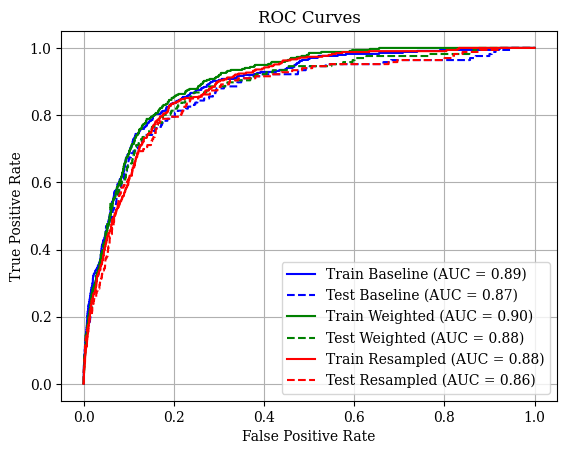

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def plot_roc(label, true_labels, predictions, color, linestyle='-'):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

plot_roc("Train Baseline", y_train_array, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test_array, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", y_train_array, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[2], linestyle='--')

plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [59]:
confusion_matrix_result = confusion_matrix(y_test_array, test_predictions_resampled_labels)
print(confusion_matrix_result)

[[7583 8751]
 [   9  157]]


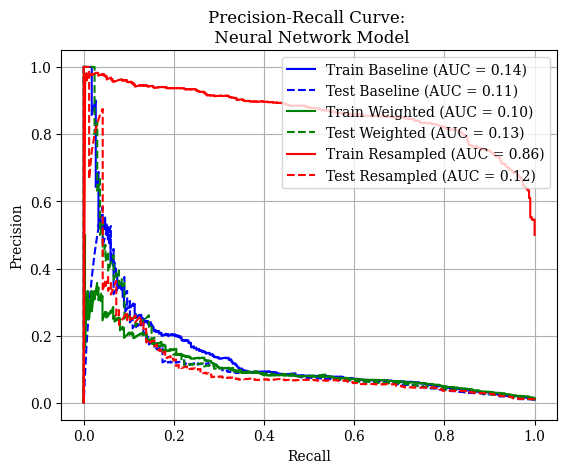

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_prc(label, y_true, y_scores, color, linestyle='-'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = auc(recall, precision)

    plt.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')
colors = ['b', 'g', 'r']

plot_prc("Train Baseline", y_train_array, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test_array, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train_array, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[2], linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: \n Neural Network Model')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
516/516 ━━━━━━━━

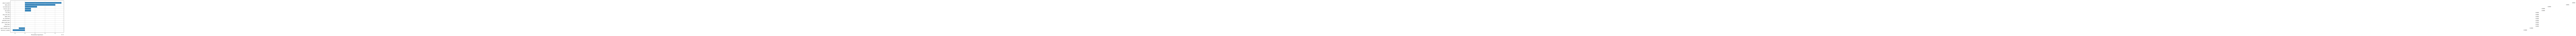

In [63]:
from sklearn.metrics import accuracy_score

def permutation_importance(model, X_val, y_val, metric=accuracy_score, n_repeats=5):
    baseline_score = metric(y_val, np.round(model.predict(X_val)))

    importances = []
    for i in range(X_val.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            X_val_permuted = X_val.copy()
            np.random.shuffle(X_val_permuted[:, i])
            permuted_score = metric(y_val, np.round(model.predict(X_val_permuted)))
            importance = baseline_score - permuted_score
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))

    return np.array(importances)

importances = permutation_importance(base_model, X_test_array, y_test_array)
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(np.arange(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.grid(True)

for bar, importance in zip(bars, importances[sorted_idx]):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{importance:.4f}', va='center', ha='left')

plt.show()